### [Fashion MNIST & IRIS ] 모델 구현

-  커스텀 데이터셋 생성

- 커스텀 모델 생성

- 학습/테스트 함수 생성

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optima
from torch.utils.data import DataLoader, Dataset


from torchinfo import summary
from torchmetrics.classification import F1Score
from sklearn.model_selection import train_test_split

In [131]:
TRAIN_FILE = '../data/fashion-mnist_train.csv'
TEST_FILE  = '../data/fashion-mnist_test.csv'

In [132]:
# random_state: 33
torch.manual_seed(33)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Notice")
print(f"DEVICE: {DEVICE}")
print(f"torch ver: {torch.__version__}")


Notice
DEVICE: cpu
torch ver: 2.4.1


- User Defined Datasets Class
---
- class function: base on file path, datasets
- parents class: torch.utils.data.Dataset
- class name: FileDataSet
- parameter: file_path
---

---
- function skill: data type transform DataFrame
- function name: cover_dataframe
- parameter: file_path, header=0
- function return: DataFrame
---

In [133]:
def cover_dataframe(file_path,header=0):
    ext = file_path.rsplit('.')[-1]
    
    if ext == 'csv':
        return pd.read_csv(file_path, header=header)
    elif ext == 'json':
        return pd.read_json(file_path, header=header)
    elif ext in ['xlsx', 'xls']:
        return pd.read_excel(file_path, header=header)
    else:
        return pd.read_table(file_path, header=header)

In [134]:
class TrainFileDataSet(Dataset):
    def __init__(self, file_path):
        super().__init__()
        data_df = cover_dataframe(file_path)

        self.feature_df = data_df[data_df.columns[1:]]
        self.label_df = data_df[[data_df.columns[0]]]
        # if self.label_df[self.label_df.columns[0]].dtype == 'object':
        #     label_df = pd.get_dummies(self.label_df)
        #     label_df = label_df.astype('int64')
        #     self.label_df = label_df
            
        # random_state: 33
        # stratify: self.label_df
        # train : val = 7 : 3
        X_train, X_val, y_train, y_val = train_test_split(self.feature_df, self.label_df, random_state=33, stratify=self.label_df, test_size=0.3)
        self.X_train = X_train
        self.X_val = torch.FloatTensor(X_val.values)
        self.y_train = y_train
        self.y_val = torch.FloatTensor(y_val.values)
        
        self.n_row = self.X_train.shape[0]
        self.features = self.feature_df.columns
        self.n_features = self.feature_df.shape[1]
        self.labels = data_df.iloc[:, 0].unique()
        self.n_labels = len(self.labels)
        
    def __len__(self):
        return self.n_row
    
    def __getitem__(self, idx):
        
        X_train = torch.FloatTensor(self.X_train.iloc[idx].values)
        # X_test = torch.FloatTensor(self.X_val.iloc[idx].values)
        y_train = torch.FloatTensor(self.y_train.iloc[idx].values)
        # y_test = torch.FloatTensor(self.y_val.iloc[idx].values)
        return X_train, y_train
        

In [135]:
class TestFileDataSet(Dataset):
    def __init__(self, file_path):
        super().__init__()
        data_df = cover_dataframe(file_path)

        feature_df = data_df[data_df.columns[1:]]
        label_df = data_df[[data_df.columns[0]]]
        self.feature_ts = torch.FloatTensor(feature_df.values)
        self.label_ts = torch.FloatTensor(label_df.values)
        
        # if self.label_df[self.label_df.columns[0]].dtype == 'object':
        #     label_df = pd.get_dummies(self.label_df)
        #     label_df = label_df.astype('int64')
        #     self.label_df = label_df
        
        self.n_row = feature_df.shape[0]
        self.features = feature_df.columns
        self.n_features = feature_df.shape[1]
        self.labels = data_df.iloc[:, 0].unique()
        self.n_labels = len(self.labels)
        
    def __len__(self):
        return self.n_row
    
    def __getitem__(self, idx):
            feature_ts = self.feature_df.iloc[idx]
            label_ts = self.label_df.iloc[idx]
            return feature_ts, label_ts

- Model Instance
---
- ANN classification model
    - input layer: input feature
    - output layer: predict label
    - hidden layer: dynamic? or fixed?
- parents class: nn.Module

- Model structure
---
- learning method: supervised learninf, multi-classification
- learning algorithm: perceptron concept base on linear model

    - input layer: input 784, output 500, activation function: ReLU
    - hidden layer: input 500, output 200, activation function: ReLU
    - hidden layer: input 200, output 50, activation function: ReLU
    - output layer: input 50, output 10, activation function: None (지원안함. nn.CrossEntropyLoss 알아서 계산)

In [136]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_layer = nn.Linear(784, 500)
        self.hidden_layer_1 = nn.Linear(500, 200)
        self.hidden_layer_2 = nn.Linear(200, 50)
        self.output_layer = nn.Linear(50, 10)
        
    def forward(self, x):
        y = F.relu(self.input_layer(x))
        y = F.relu(self.hidden_layer_1(y))
        y = F.relu(self.hidden_layer_2(y))
        y = self.output_layer(y)
        return y

- validation & test function
---
- function name: testing
- parameter: model, x, y
- function return: loss, score
- `must not update weight & bais`

In [137]:
def testing(model, X_ts, y_ts):
    with torch.no_grad():
        y_ts = y_ts.reshape(-1).long()
        pred = model(X_ts)
        
        loss = nn.CrossEntropyLoss()(pred, y_ts)
        
        score = F1Score(task='multiclass', num_classes=10)(pred, y_ts)
    
    return loss, score

- model learning
---
- function name: training
- parameter: model, epochs, lr, batch_size, dataset
- function return: loss, score

In [178]:
def tarining(dataset, model, epochs, lr, batch):
    train_val_loss = {'train':[], 'val':[]}
    train_val_score = {'train':[], 'val':[]}
    optmizer = optima.Adam(model.parameters(), lr=lr)
    data_dl = DataLoader(dataset, batch_size=batch)
    
    for epoch in range(1, epochs+1):
        total_train_loss, total_train_score = 0, 0
        
        for X_train, y_train in data_dl:
            batch_cnt = dataset.n_row / batch
            y_train = y_train.reshape(-1).long()
            
            pred = model(X_train)
            
            loss = nn.CrossEntropyLoss()(pred, y_train)
            total_train_loss += loss
            
            score = F1Score(task='multiclass', num_classes=10)(pred, y_train)
            total_train_score += score
            
            optmizer.zero_grad()
            loss.backward()
            optmizer.step()
        
        X_val, y_val = dataset.X_val, dataset.y_val
        val_loss, val_score = testing(model, X_val, y_val)
        
        
        loss_train = (total_train_loss/batch_cnt).item()
        score_train = (total_train_score/batch_cnt).item()
        
        train_val_loss['train'].append(loss_train)
        train_val_score['train'].append(score_train)
        train_val_loss['val'].append(val_loss.item())
        train_val_score['val'].append(val_score.item())
        
        if epoch%5 == 0:
            print(f"[{epoch:5}/{epochs:5}]  [Train]      loss: {loss_train:.6f}, score: {score_train:.6f}")
            print(f"[{epoch:5}/{epochs:5}]  [Validation] loss: {val_loss.item():.6f}, score: {val_score.item():.6f}")
    
    return train_val_loss, train_val_score

In [139]:
train_ds = TrainFileDataSet(TRAIN_FILE)
test_ds = TestFileDataSet(TEST_FILE)

In [140]:
train_ds.n_features, train_ds.n_labels, train_ds.n_row

(784, 10, 42000)

In [179]:
model = ClassificationModel()

In [180]:
print(model, end='\n\n')
summary(model)

ClassificationModel(
  (input_layer): Linear(in_features=784, out_features=500, bias=True)
  (hidden_layer_1): Linear(in_features=500, out_features=200, bias=True)
  (hidden_layer_2): Linear(in_features=200, out_features=50, bias=True)
  (output_layer): Linear(in_features=50, out_features=10, bias=True)
)



Layer (type:depth-idx)                   Param #
ClassificationModel                      --
├─Linear: 1-1                            392,500
├─Linear: 1-2                            100,200
├─Linear: 1-3                            10,050
├─Linear: 1-4                            510
Total params: 503,260
Trainable params: 503,260
Non-trainable params: 0

In [181]:

# train_dl = DataLoader(train_ds, batch_size=64)
loss_dict, score_dict = tarining(train_ds, model, 25, 0.001, 128)

[    5/   25]  [Train]      loss: 0.328161, score: 0.881571
[    5/   25]  [Validation] loss: 0.424804, score: 0.858833
[   10/   25]  [Train]      loss: 0.277029, score: 0.900357
[   10/   25]  [Validation] loss: 0.416347, score: 0.868000
[   15/   25]  [Train]      loss: 0.249096, score: 0.912619
[   15/   25]  [Validation] loss: 0.398464, score: 0.875278
[   20/   25]  [Train]      loss: 0.225341, score: 0.919190
[   20/   25]  [Validation] loss: 0.405317, score: 0.877389
[   25/   25]  [Train]      loss: 0.208587, score: 0.925357
[   25/   25]  [Validation] loss: 0.394189, score: 0.877111


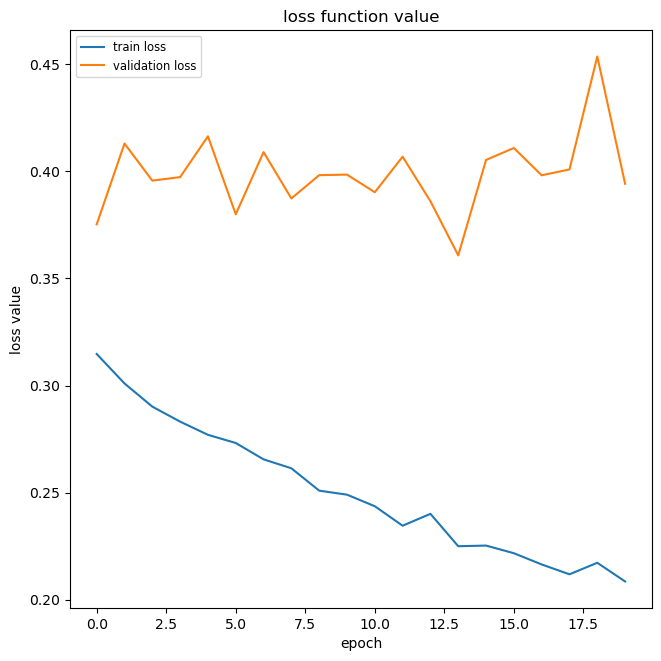

In [182]:
plt.figure(figsize=(7.5, 7.5))
# plt.plot(loss_dict['train'], label=f'train loss, mean: {sum(loss_dict['train'])/len(loss_dict['train']):.4f}, min: {min(loss_dict['train']):.4f}')
# plt.plot(loss_dict['val'], label=f'validation loss, mean: {sum(loss_dict['val'])/len(loss_dict['val']):.4f}, min: {min(loss_dict['val']):.4f}')
plt.plot(loss_dict['train'][5:], label=f'train loss')
plt.plot(loss_dict['val'][5:], label=f'validation loss')

plt.title('loss function value')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend(fontsize='small')
plt.show()

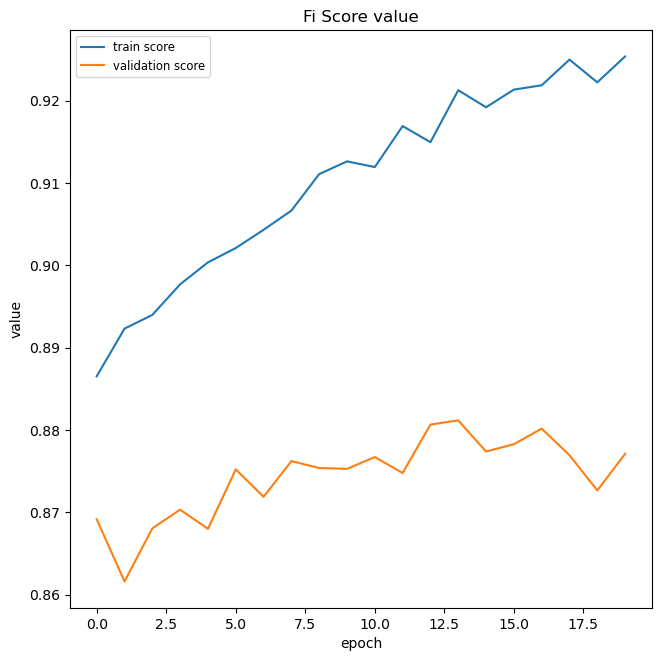

In [183]:
plt.figure(figsize=(7.5, 7.5))
plt.plot(score_dict['train'][5:], label=f'train score')
plt.plot(score_dict['val'][5:], label=f'validation score')

plt.title('Fi Score value')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend(fontsize='small')
plt.show()

In [184]:
test_loss, test_f1 = testing(model, test_ds.feature_ts, test_ds.label_ts)

print(f"test loss    : {test_loss.item():10.8f}")
print(f"test F1 Score: {test_f1.item()*100:.2f} %\n")


test loss    : 0.37746266
test F1 Score: 88.11 %



- loss_dict, score_dict = tarining(train_ds, model, 100, 0.001, 64)
    - test f1 score: 88.16 %
- loss_dict, score_dict = tarining(train_ds, model, 100, 0.001, 32)
    - test f1 score: 87.57%

- epoch: 100, learning rate: 0.01, batch size: 64
    - test f1 score: 10.00 %
- epoch: 100, learning rate: 0.01, batch size: 32
    - test f1 score: 10.00 %

- epoch: 100, learning rate: 0.001, batch size: 128
    - test f1 score: 87.84%
- epoch: 50, learning rate: 0.001, batch size: 128
    - test f1 score: 87.80 %
- epoch: 25, learning rate: 0.001, barch size: 128
    - test f1 score: 88.11 %